In [101]:
# 데이터 처리
import pandas
import numpy
from scipy import stats

# 데이터 그리기
import seaborn
import matplotlib
import matplotlib.pyplot as plt

# # 노트북 안에 그래프를 그리기 위해
# %matplotlib inline

# # 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
# plt.style.use("ggplot")

# # 그래프에서 마이너스 폰트 깨지는 현상 대처
# matplotlib.rcParams['axes.unicode_minus']=False

# 모델링
from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [102]:
train = pandas.read_csv("C:/Users/Be Irreplaceable/Desktop/kaggle/bike_sharing/train.csv", parse_dates=["datetime"])
test = pandas.read_csv("C:/Users/Be Irreplaceable/Desktop/kaggle/bike_sharing/test.csv", parse_dates=["datetime"])

In [103]:
train.shape

(10886, 12)

In [104]:
test.shape

(6493, 9)

In [105]:
# Feature Engineering
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [106]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

<AxesSubplot:title={'center':'test_windspeed'}, xlabel='windspeed', ylabel='count'>

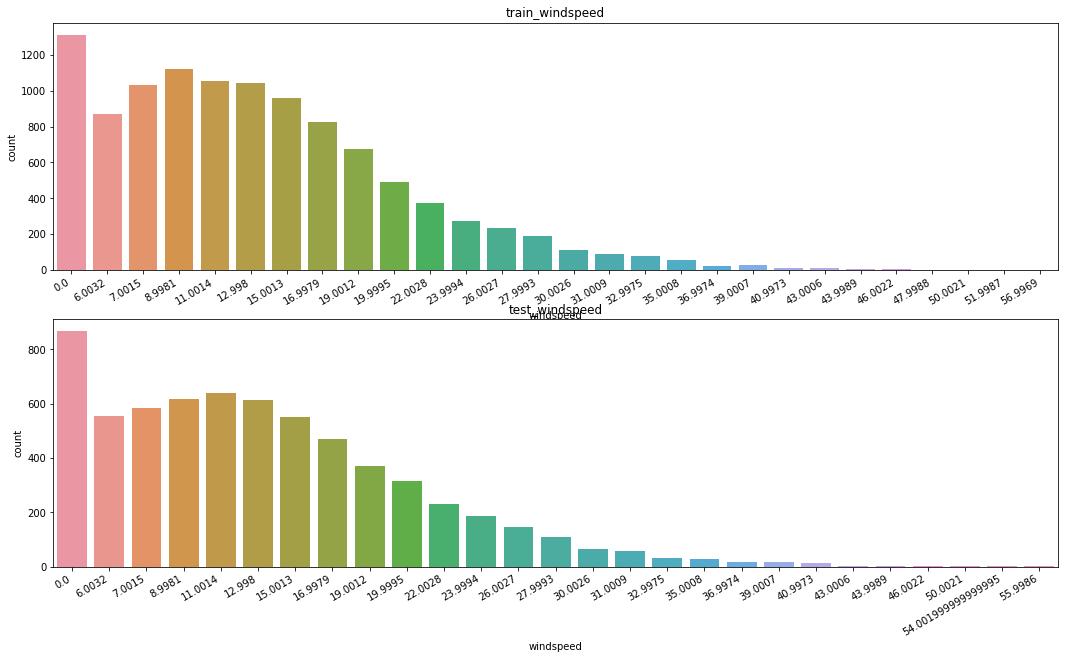

In [107]:
# windspeed 풍속에 0 값이 가장 많다. => 잘못 기록된 데이터를 고쳐줄 필요가 있음
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18, 10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha="right")
axes[0].set(ylabel="Count", title="train_windspeed")
seaborn.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha="right")
axes[1].set(ylabel="Count", title="test_windspeed")
seaborn.countplot(data=test, x="windspeed", ax=axes[1])

In [108]:
'''
풍속의 0값에 특정 값을 넣어준다.
평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 될 것 같진 않다.
그래서, 풍속이 0인 것과 아닌 것으로 세트를 나누어, 머신러닝으로 예측해서 아예 풍속을 얘가 직접 넣어주도록 한다.
'''

'\n풍속의 0값에 특정 값을 넣어준다.\n평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 될 것 같진 않다.\n그래서, 풍속이 0인 것과 아닌 것으로 세트를 나누어, 머신러닝으로 예측해서 아예 풍속을 얘가 직접 넣어주도록 한다.\n'

In [109]:
# from sklearn.ensemble import RandomForestClassifier 사전 선언 필요!
# 풍속이 0인 데이터가 test data set
# 풍속이 0이 아닌 데이터가 train data set

def predict_windspeed(data):
    # [전처리] 풍속이 0인 것과 아닌 것을 나누어준다.
    dataWind0 = data.loc[data["windspeed"] == 0]
    datawindNot0 = data.loc[data["windspeed"] != 0]
    
    # [전처리] 풍속을 예측할 feature를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # [전처리] 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    datawindNot0["windspeed"] = datawindNot0["windspeed"].astype("str")

    # [모델링] 랜던포레스트 분류 모델을 사용한다.
    rfModel_wind = RandomForestClassifier()

    # [학습] wCol에 있는 feature값들을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(datawindNot0[wCol], datawindNot0["windspeed"]) # fit(X_train, Y_train)
    
    # [예측] 학습한 값을 바탕으로, 풍속이 0으로 기록된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol]) # predict(X_test)

    # 값을 모두 예측 후 비교해보기 위해 예측한 값을 넣어줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = datawindNot0

    # 값이 0으로 기록된 풍속을 예측한 값으로 다시 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터 타입을 float으로 지정해준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop("index", inplace=True, axis=1)

    return data

<AxesSubplot:title={'center':'train windspeed'}, xlabel='windspeed', ylabel='count'>

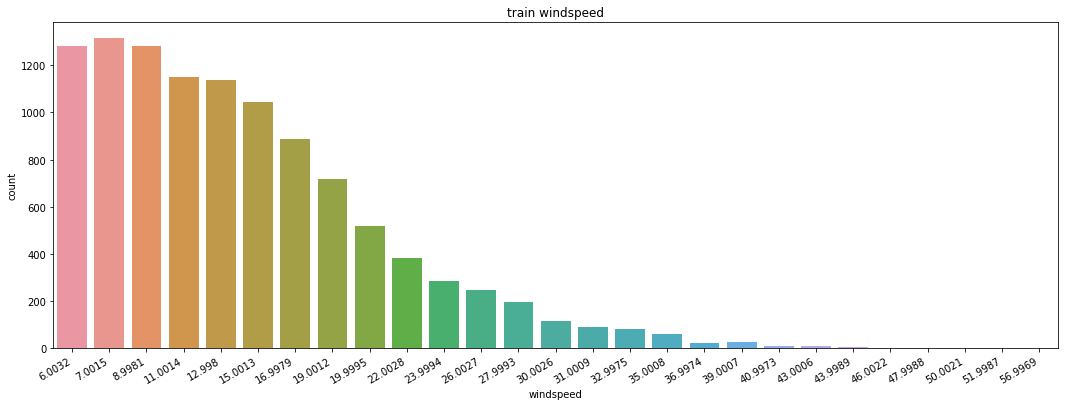

In [110]:
# 0값을 조정한다
train = predict_windspeed(train)
# test = predict_windspeed(test)

fig, axl = plt.subplots()
fig.set_size_inches(18, 6)

plt.sca(axl)
plt.xticks(rotation=30, ha="right") # rotation 30은, 글씨 각도를 30도 기울여서 글씨가 겹쳐보이지 않게 하는 기능
axl.set(ylabel="Count", title="train windspeed")
seaborn.countplot(data=train, x="windspeed", ax=axl)

In [111]:
'''
<Feature Selection>
본격적으로 이제 피처 선택
1. 신호와 잡음을 구분해야 한다.
2. 피처가 많다고 해서 무조건 좋은 성능을 내지는 않는다. 너무 적어도 데이터가 너무 적어서 신뢰하기 힘들다. 적당한 최적값을 찾는 게 중요.
3. 피처를 하나씩 추가하고 변경해가면서 성능이 좋지 않은 피처는 제거하도록 한다.

연속형 feature : ["temp", "humidity", "windspeed", "atemp", ...] 숫자에 따라서 그 강약을 알 수 있다.(온도가 높다 낮다, 풍속이 세다 약하다 등)
범주형 feature : ["season", "weather", ...] 숫자가 강약을 의미하는 게 아니라, 말 그대로 범주를 구분하기 위한 숫자를 사용
'''

'\n<Feature Selection>\n본격적으로 이제 피처 선택\n1. 신호와 잡음을 구분해야 한다.\n2. 피처가 많다고 해서 무조건 좋은 성능을 내지는 않는다. 너무 적어도 데이터가 너무 적어서 신뢰하기 힘들다. 적당한 최적값을 찾는 게 중요.\n3. 피처를 하나씩 추가하고 변경해가면서 성능이 좋지 않은 피처는 제거하도록 한다.\n\n연속형 feature : ["temp", "humidity", "windspeed", "atemp", ...] 숫자에 따라서 그 강약을 알 수 있다.(온도가 높다 낮다, 풍속이 세다 약하다 등)\n범주형 feature : ["season", "weather", ...] 숫자가 강약을 의미하는 게 아니라, 말 그대로 범주를 구분하기 위한 숫자를 사용\n'

In [112]:
# 범주형 feature만 따로 분류해서 category 타입으로 바꿔준다.
categorial_feature_names = ["season", "holiday", "workingday", "weather", "dayofweek", "month", "year", "hour"]

for var in categorial_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [113]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed", "year", "hour", "dayofweek", "holiday", "workingday"]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [114]:
# 선택해준 feature로 새로운 행렬을 만든다.
X_train = train[feature_names]

print(X_train.shape)
X_train.head(5)

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [115]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head(5)

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [116]:
y_train = train["count"]

print(y_train.shape)
y_train.head(5)

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

In [121]:
# Cross Validation 교차검증 : Kfolt 방식으로 계산할꺼임
K_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [122]:
# RandomForest 모델 적용
max_depth_list = []

model = RandomForestClassifier(n_jobs=-1, random_state=0) # estimator 값이 높으면 좀 더 좋은 성능을 낸다. 대신 해석간도 오래걸림

model

RandomForestClassifier(n_jobs=-1, random_state=0)

In [119]:
# %time score = cross_val_score(model, X_train, y_train, cv=K_fold, scoring="accuracy")
# score = score.mean()
# print("Score = {0:.5f}".format(score))

In [120]:
# model.fit(X_train, y_train)

MemoryError: could not allocate 107741184 bytes

In [123]:
# # 예측
# predictions = model.predict(X_test)

# print(predictions.shape)
# predictions[0:10]

In [124]:
# # 예측 데이터 시각화
# fig, (ax1, ax2) = plt.subplots()
# fig.set_size_inches(12, 5)
# seaborn.distplot(y_train, ax=ax1, bins=50)
# ax1.set(title="train") 
# seaborn.distplot(predictions, ax= ax2, bins=50)
# ax2.set(title="test")

In [125]:
# # 제출하기
# submission = pandas.read_csv("C:/Users/Be Irreplaceable/Desktop/kaggle/bike_sharing/sampleSubmission.csv")
# submission

# submission["count"] = predictions

# print(submission.shape)
# submission.head(5)

In [ ]:
# submission.to_csv("C:\Users\Be Irreplaceable\Desktop\kaggle\bike_sharing\Score_{0:.5f}_submission.csv".format(score), index=False)